<a href="https://colab.research.google.com/github/ArmandOvanessians/Disorder/blob/main/explain_transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torch
!pip install captum

import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch
import matplotlib.pyplot as plt
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader, Subset
# Google Colab Specific Imports
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:

class SequenceDataset(Dataset):
    def __init__(self, df, feature_start_col='REP_Q2', feature_end_col='omega*', class_col='Class'):
        """
        Initializes the dataset by creating a list of sequences from the DataFrame.

        Parameters:
        - df: DataFrame containing clone_id, node features, and class labels.
        - feature_start_col: Column name indicating the start of the node feature columns.
        - feature_end_col: Column name indicating the end of the node feature columns.
        - class_col: Column name for the label. Defaults to 'Class'.
        """
        self.sequences = []

        # Group the DataFrame by clone_id
        for clone_id, group in df.groupby('ID'):
            # Extract node features and concatenate them into one sequence vector
            node_features = group.loc[:, feature_start_col:feature_end_col].values
            sequence_vector = torch.tensor(node_features.flatten(), dtype=torch.float)

            # Assign the mean label to the sequence
            label = torch.tensor(group[class_col].mean(), dtype=torch.float)

            # Append the sequence, label, and clone_id as a dictionary
            self.sequences.append({'sequence': sequence_vector, 'label': label, 'ID': clone_id})

    def __len__(self):
        # Return the number of sequences
        return len(self.sequences)

    def __getitem__(self, idx):
        # Retrieve a single sequence and its label
        data = self.sequences[idx]
        return data['sequence'], data['label'], data['ID']


In [3]:
class TransformerBinaryClassifier(nn.Module):
    def __init__(self, input_dim, num_heads=8, num_layers=4, hidden_dim=128, dropout=0.1):
        super(TransformerBinaryClassifier, self).__init__()

        # Linear layer to project input features to the transformer dimension
        self.embedding = nn.Linear(input_dim, hidden_dim)

        # Transformer Encoder Layer
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=hidden_dim,
            nhead=num_heads,
            dropout=dropout,
            dim_feedforward=hidden_dim * 6  # Increase feedforward dimension
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # Classification head with additional layer
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        # Embed input features
        x = self.embedding(x)  # Shape: (batch_size, sequence_length, hidden_dim)

        # Ensure x has three dimensions
        if x.dim() == 2:
            x = x.unsqueeze(1)  # Shape: (batch_size, 1, hidden_dim)

        # Permute for transformer input (transformer expects shape: [sequence_length, batch_size, hidden_dim])
        x = x.permute(1, 0, 2)

        # # Pass through the transformer encoder
        # x = self.transformer(x)
         # Capture attention weights during forward pass
        attention_weights = []
        for layer in self.transformer.layers:
            x, attn_weights = layer.self_attn(x, x, x, need_weights=True)
            attention_weights.append(attn_weights)  # List of attention matrices per layer


        # Permute back: (batch_size, sequence_length, hidden_dim)
        x = x.permute(1, 0, 2)

        # Use max pooling instead of mean pooling
        x = x.max(dim=1).values  # Shape: (batch_size, hidden_dim)

        # Classification head
        logits = self.classifier(x).squeeze(-1)  # Shape: (batch_size,)

        return logits, attention_weights

In [4]:
from captum.attr import IntegratedGradients
from captum.attr import IntegratedGradients

def compute_integrated_gradients(model, input_tensor, baseline=None):
    model.eval()

    # Define forward function for IntegratedGradients
    def forward_func(inputs):
        logits, _ = model(inputs)  # Only use the classification logits from the model output
        return logits.view(-1)  # Ensure output is [batch_size], i.e., a scalar for each sample

    # Initialize Integrated Gradients with the adjusted forward function
    ig = IntegratedGradients(forward_func)

    # Set a baseline input if not provided
    if baseline is None:
        baseline = torch.zeros_like(input_tensor)  # Use a zero vector as the baseline

    # Compute attributions without target (binary classification defaults to single output)
    attributions = ig.attribute(input_tensor, baselines=baseline)
    return attributions.squeeze().cpu().numpy()


In [5]:
data = '/content/drive/My Drive/Disorder/Input_data/BINTU_FULL.csv'
df = pd.read_csv(data)
df = df.iloc[:,1:]
df.head()
start = "REP_Q2"
end = "omega*"
# Initialize the dataset with the cleaned DataFrame
dataset = SequenceDataset(df, feature_start_col='REP_Q2', feature_end_col='omega*', class_col='Class')

# Define a DataLoader to iterate over the dataset in batches
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
first_sequence, _, _ = dataset[0]
input_dim = first_sequence.shape[-1]

#model_path = '/content/drive/My Drive/Disorder/Input_data/BINTU_FULL.csv'
model_save_path = '/content/drive/My Drive/Disorder/Models/BINTU_FULL/Trarnsformer_Model_L2_AUgmented_weights.pth'
# Load the model weights
model = TransformerBinaryClassifier(
    input_dim=input_dim,
    num_heads=8,
    num_layers=4,
    hidden_dim=128,
    dropout=0.1
).to(device)

model.load_state_dict(torch.load(model_save_path))

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
<ipython-input-5-e1a2e2a40909>:28: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you sta

<All keys matched successfully>

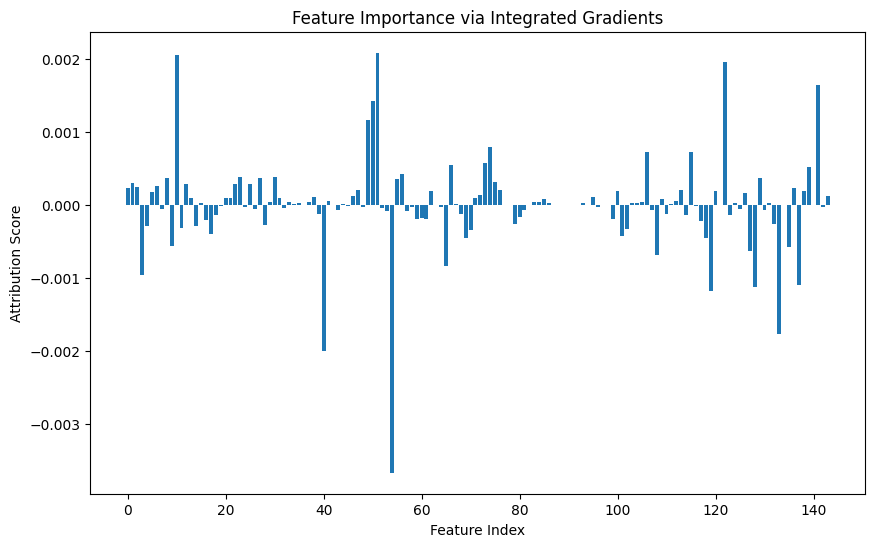

In [6]:
input_tensor = dataset[0][0].unsqueeze(0).to(device)  # Adjust based on dataset structure
attributions = compute_integrated_gradients(model, input_tensor)

# Plot the feature importances
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.bar(range(len(attributions)), attributions)
plt.xlabel("Feature Index")
plt.ylabel("Attribution Score")
plt.title("Feature Importance via Integrated Gradients")
plt.show()


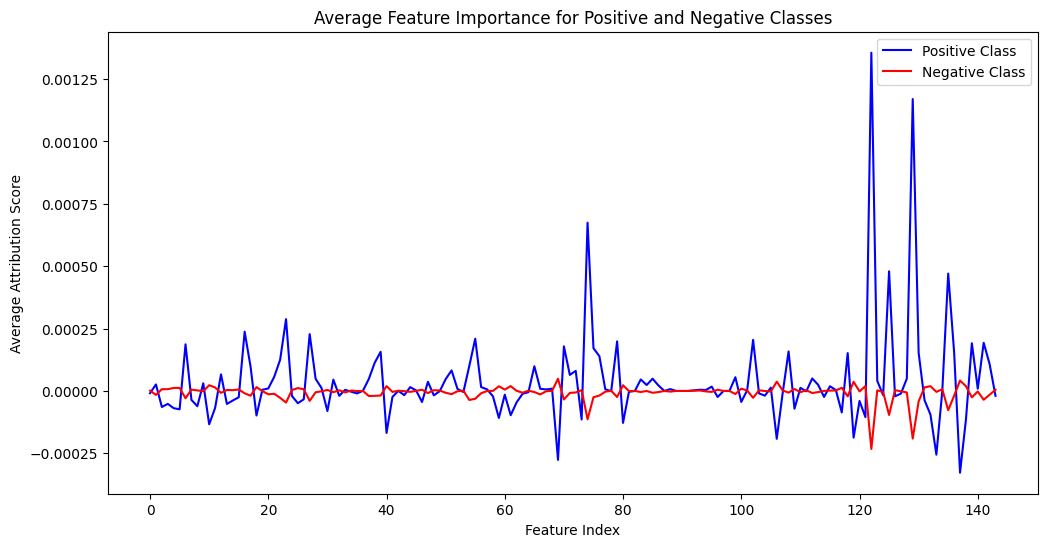

In [7]:
from captum.attr import IntegratedGradients
import torch
import numpy as np
import matplotlib.pyplot as plt

def compute_average_attributions_by_class(model, dataset, device, baseline=None):
    model.eval()
    ig = IntegratedGradients(lambda x: model(x)[0].view(-1))  # Use lambda to match output shape

    # Initialize lists to store attributions by class
    positive_class_attributions = []
    negative_class_attributions = []

    for input_tensor, label, _ in DataLoader(dataset, batch_size=1):  # Batch size 1 to process individually
        input_tensor = input_tensor.to(device)
        label = label.item()

        # Set a baseline (if not provided, use zero baseline)
        if baseline is None:
            baseline = torch.zeros_like(input_tensor)

        # Compute attributions for this input
        attributions = ig.attribute(input_tensor, baselines=baseline)
        attributions = attributions.squeeze().cpu().numpy()

        # Store attributions by class
        if label == 1:
            positive_class_attributions.append(attributions)
        else:
            negative_class_attributions.append(attributions)

    # Calculate the mean attributions across each class
    positive_class_mean_attr = np.mean(positive_class_attributions, axis=0)
    negative_class_mean_attr = np.mean(negative_class_attributions, axis=0)

    return positive_class_mean_attr, negative_class_mean_attr

# Compute average attributions for both classes
positive_class_mean_attr, negative_class_mean_attr = compute_average_attributions_by_class(
    model, dataset, device
)

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(positive_class_mean_attr, label="Positive Class", color="blue")
plt.plot(negative_class_mean_attr, label="Negative Class", color="red")
plt.xlabel("Feature Index")
plt.ylabel("Average Attribution Score")
plt.title("Average Feature Importance for Positive and Negative Classes")
plt.legend()
plt.show()


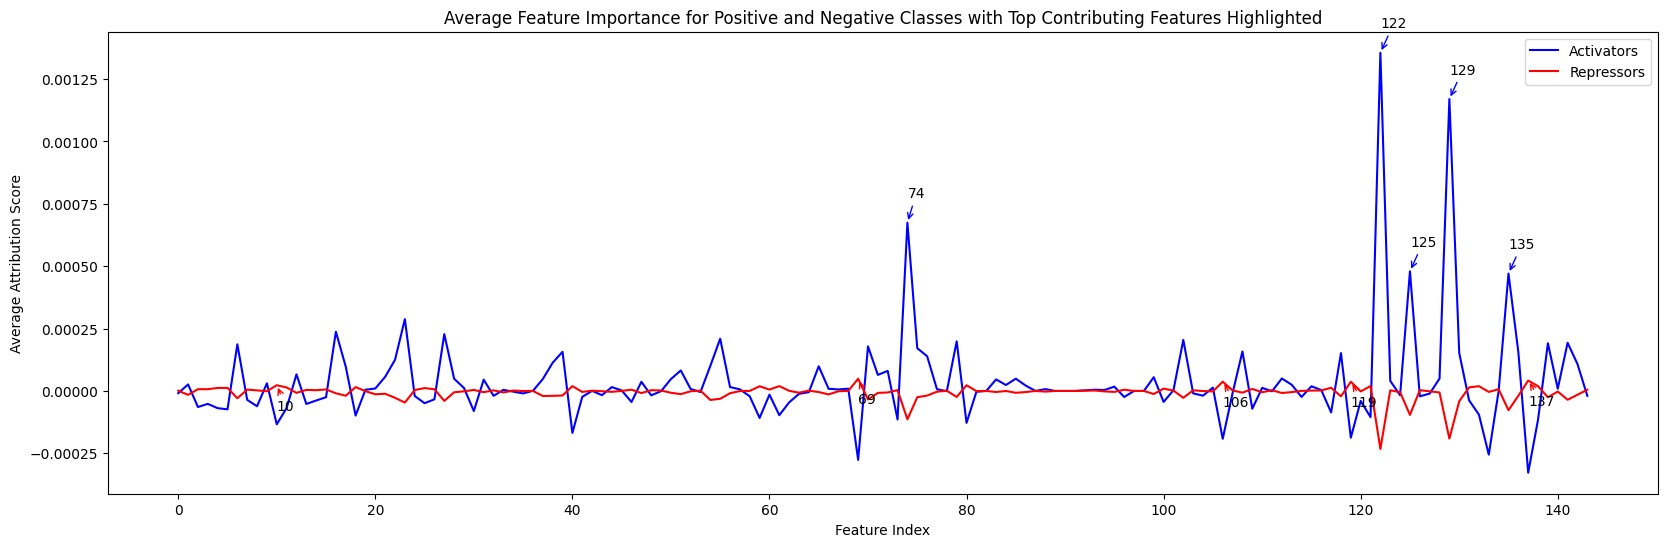

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Number of top contributing features to highlight
top_n = 5

# Find the indices of the top contributing features
positive_top_indices = np.argsort(positive_class_mean_attr)[-top_n:]  # Top N positive features
negative_top_indices = np.argsort(negative_class_mean_attr)[-top_n:]  # Top N negative features

# Plotting with annotations
plt.figure(figsize=(20, 6))
plt.plot(positive_class_mean_attr, label="Activators", color="blue")
plt.plot(negative_class_mean_attr, label="Repressors", color="red")

# Annotate top contributing features for positive class
for idx in positive_top_indices:
    plt.annotate(f"{idx}", xy=(idx, positive_class_mean_attr[idx]),
                 xytext=(idx, positive_class_mean_attr[idx] + 0.0001),
                 arrowprops=dict(arrowstyle="->", color="blue"))

# Annotate top contributing features for negative class
for idx in negative_top_indices:
    plt.annotate(f"{idx}", xy=(idx, negative_class_mean_attr[idx]),
                 xytext=(idx, negative_class_mean_attr[idx] - 0.0001),
                 arrowprops=dict(arrowstyle="->", color="red"))

# Add labels and title
plt.xlabel("Feature Index")
plt.ylabel("Average Attribution Score")
plt.title("Average Feature Importance for Positive and Negative Classes with Top Contributing Features Highlighted")
plt.legend()
plt.show()


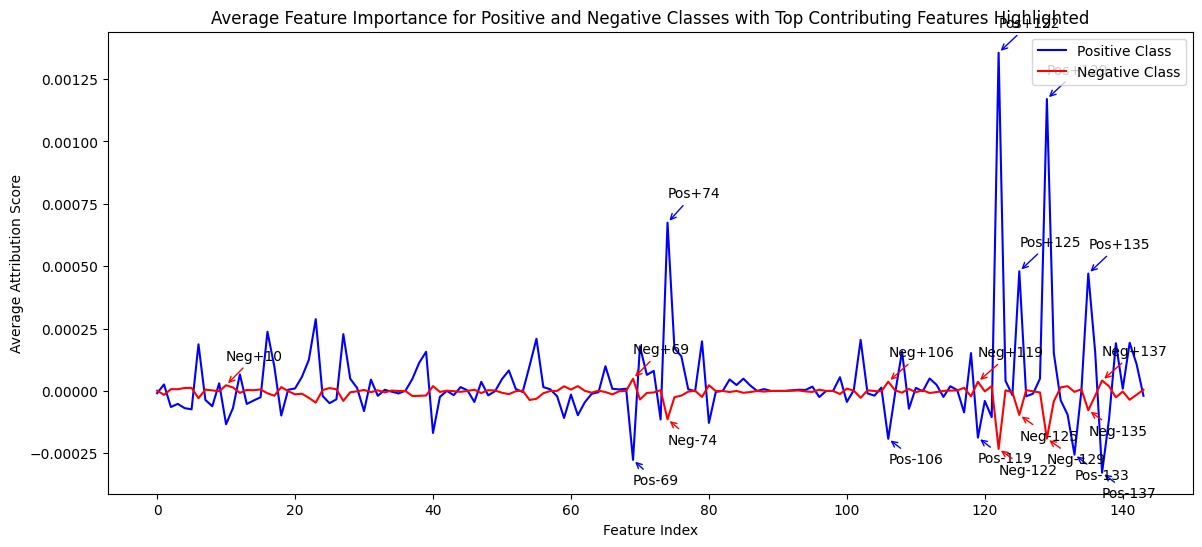

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Number of top contributing positive and negative features to highlight
top_n = 5

# Identify top positive and negative contributing features for each class
positive_top_positive_indices = np.argsort(positive_class_mean_attr)[-top_n:]  # Top N most positive features
positive_top_negative_indices = np.argsort(positive_class_mean_attr)[:top_n]   # Top N most negative features

negative_top_positive_indices = np.argsort(negative_class_mean_attr)[-top_n:]  # Top N most positive features
negative_top_negative_indices = np.argsort(negative_class_mean_attr)[:top_n]   # Top N most negative features

# Plotting with annotations
plt.figure(figsize=(20, 6))
plt.plot(positive_class_mean_attr, label="Positive Class", color="blue")
plt.plot(negative_class_mean_attr, label="Negative Class", color="red")

# Annotate top positive contributing features for the positive class
for idx in positive_top_positive_indices:
    plt.annotate(f"Pos+{idx}", xy=(idx, positive_class_mean_attr[idx]),
                 xytext=(idx, positive_class_mean_attr[idx] + 0.0001),
                 arrowprops=dict(arrowstyle="->", color="blue"))

# Annotate top negative contributing features for the positive class
for idx in positive_top_negative_indices:
    plt.annotate(f"Pos-{idx}", xy=(idx, positive_class_mean_attr[idx]),
                 xytext=(idx, positive_class_mean_attr[idx] - 0.0001),
                 arrowprops=dict(arrowstyle="->", color="blue"))

# Annotate top positive contributing features for the negative class
for idx in negative_top_positive_indices:
    plt.annotate(f"Neg+{idx}", xy=(idx, negative_class_mean_attr[idx]),
                 xytext=(idx, negative_class_mean_attr[idx] + 0.0001),
                 arrowprops=dict(arrowstyle="->", color="red"))

# Annotate top negative contributing features for the negative class
for idx in negative_top_negative_indices:
    plt.annotate(f"Neg-{idx}", xy=(idx, negative_class_mean_attr[idx]),
                 xytext=(idx, negative_class_mean_attr[idx] - 0.0001),
                 arrowprops=dict(arrowstyle="->", color="red"))

# Add labels and title
plt.xlabel("Feature Index")
plt.ylabel("Average Attribution Score")
plt.title("Average Feature Importance for Positive and Negative Classes with Top Contributing Features Highlighted")
plt.legend()
plt.show()



5 [ 0.60582129 -0.76264894]
7 [-0.36518861  0.69498255]


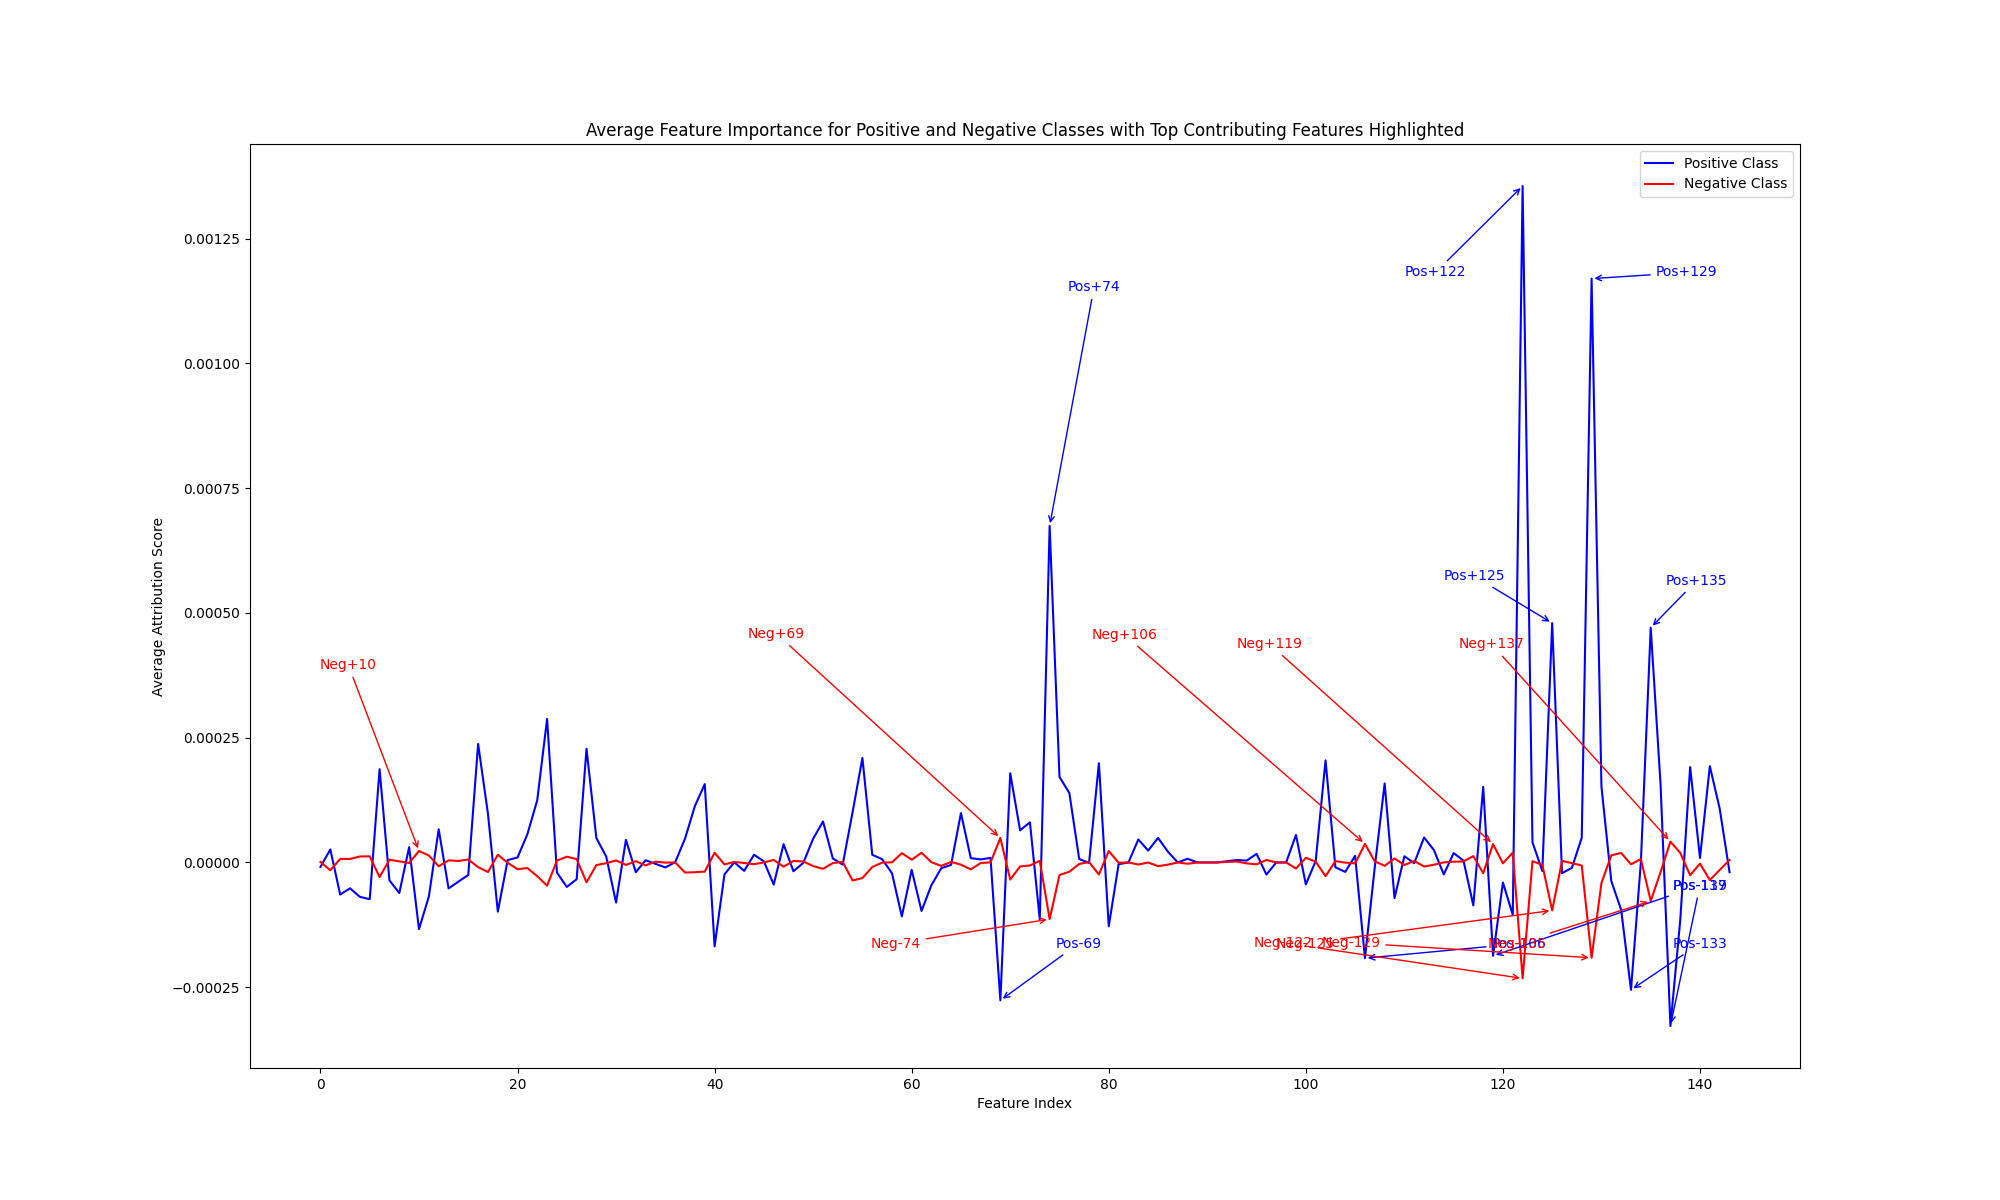

In [103]:
from adjustText import adjust_text

# Number of top contributing positive and negative features to highlight
top_n = 5

# Identify top positive and negative contributing features for each class
positive_top_positive_indices = np.argsort(positive_class_mean_attr)[-top_n:]  # Top N most positive features
positive_top_negative_indices = np.argsort(positive_class_mean_attr)[:top_n]   # Top N most negative features
negative_top_positive_indices = np.argsort(negative_class_mean_attr)[-top_n:]  # Top N most positive features
negative_top_negative_indices = np.argsort(negative_class_mean_attr)[:top_n]   # Top N most negative features

# Plotting with annotations
plt.figure(figsize=(20, 12))
plt.plot(positive_class_mean_attr, label="Positive Class", color="blue")
plt.plot(negative_class_mean_attr, label="Negative Class", color="red")

# Collect all annotations to adjust later
annotations = []

# Adjust xytext offset for cleaner placement far from the plot
for idx in positive_top_positive_indices:
    ann = plt.annotate(f"Pos+{idx}", xy=(idx, positive_class_mean_attr[idx]),
                       xytext=(idx + 15, positive_class_mean_attr[idx] + 0.0005),  # Increased offset
                       arrowprops=dict(arrowstyle="->", color="blue"), color="blue")
    annotations.append(ann)

for idx in positive_top_negative_indices:
    ann = plt.annotate(f"Pos-{idx}", xy=(idx, positive_class_mean_attr[idx]),
                       xytext=(idx + 15, positive_class_mean_attr[idx] - 0.0005),  # Increased offset
                       arrowprops=dict(arrowstyle="->", color="blue"), color="blue")
    annotations.append(ann)

for idx in negative_top_positive_indices:
    ann = plt.annotate(f"Neg+{idx}", xy=(idx, negative_class_mean_attr[idx]),
                       xytext=(idx - 15, negative_class_mean_attr[idx] + 0.0005),  # Increased offset
                       arrowprops=dict(arrowstyle="->", color="red"), color="red")
    annotations.append(ann)

for idx in negative_top_negative_indices:
    ann = plt.annotate(f"Neg-{idx}", xy=(idx, negative_class_mean_attr[idx]),
                       xytext=(idx - 15, negative_class_mean_attr[idx] - 0.0005),  # Increased offset
                       arrowprops=dict(arrowstyle="->", color="red"), color="red")
    annotations.append(ann)

# Adjust all annotations to avoid overlap with the plot lines and each other
adjust_text(annotations, only_move={'text': 'xy', 'points': 'xy'}, autoalign='xy', force_text=0.8, expand_text=(1.5, 1.5))

# Display the plot
plt.xlabel("Feature Index")
plt.ylabel("Average Attribution Score")
plt.title("Average Feature Importance for Positive and Negative Classes with Top Contributing Features Highlighted")
plt.legend()
plt.show()


In [94]:
from google.colab import output
output.enable_custom_widget_manager()

Support for third party widgets will remain active for the duration of the session. To disable support:

In [99]:
from google.colab import output
output.disable_custom_widget_manager()

In [32]:
# Load the model weights
model = TransformerBinaryClassifier(
    input_dim=input_dim,
    num_heads=8,
    num_layers=4,
    hidden_dim=128,
    dropout=0.1
).to(device)

model.load_state_dict(torch.load(model_save_path))

# Set the model to evaluation mode
model.eval()

# Get a batch of data (or a single sample) for testing
with torch.no_grad():
    for sequences, _, _ in DataLoader(dataset, batch_size=1):
        sequences = sequences.to(device)

        # Forward pass to get logits and attention weights
        logits, attention_weights = model(sequences)

        # attention_weights is a list with attention matrices for each layer
        # Each matrix in the list has shape (batch_size, num_heads, sequence_length, sequence_length)
        print("Logits:", logits)
        print("Attention weights:", attention_weights)  # Inspect attention scores for each layer
        break  # Remove break if you want to loop through the entire dataset


Logits: tensor([0.5164])
Attention weights: [tensor([[[1.]]]), tensor([[[1.]]]), tensor([[[1.]]]), tensor([[[1.]]])]


<ipython-input-32-f302d0e2bf5e>:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_save_path))


In [40]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Sample model class with attention weight extraction
class TransformerBinaryClassifier(nn.Module):
    def __init__(self, input_dim, num_heads, num_layers, hidden_dim, dropout=0.1):
        super(TransformerBinaryClassifier, self).__init__()
        self.embedding = nn.Linear(input_dim, hidden_dim)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=hidden_dim,
            nhead=num_heads,
            dropout=dropout,
            dim_feedforward=hidden_dim * 4
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.embedding(x)
        x = x.permute(1, 0, 2)
        attention_weights = []
        for layer in self.transformer.layers:
            x, attn_weights = layer.self_attn(x, x, x, need_weights=True)
            attention_weights.append(attn_weights)
        x = x.permute(1, 0, 2)
        x = x.mean(dim=1)
        logits = self.classifier(x).squeeze(-1)
        return logits, attention_weights

# Visualization function
def plot_attention_matrix(attention_matrix, layer, head):
    if attention_matrix.shape == (1,):
        print(f"Skipping Layer {layer + 1}, Head {head + 1} due to single-timestep input.")
        return
    plt.figure(figsize=(8, 6))
    sns.heatmap(attention_matrix, cmap="viridis", cbar=True)
    plt.title(f"Attention Weights - Layer {layer + 1}, Head {head + 1}")
    plt.xlabel("Key Token Position")
    plt.ylabel("Query Token Position")
    plt.show()

# Sample inference with longer sequences
with torch.no_grad():
    for sequences, _, _ in DataLoader(dataset, batch_size=1):
        sequences = sequences.to(device)
        logits, attention_weights = model(sequences)
        for layer, layer_attention in enumerate(attention_weights):
            print(f"Layer {layer + 1} attention shape: {layer_attention.shape}")
            for head in range(layer_attention.shape[1]):
                attention_matrix = layer_attention[0, head].cpu().numpy()
                print(f"Head {head + 1} attention matrix shape: {attention_matrix.shape}")
                plot_attention_matrix(attention_matrix, layer, head)
        break


Layer 1 attention shape: torch.Size([1, 1, 1])
Head 1 attention matrix shape: (1,)
Skipping Layer 1, Head 1 due to single-timestep input.
Layer 2 attention shape: torch.Size([1, 1, 1])
Head 1 attention matrix shape: (1,)
Skipping Layer 2, Head 1 due to single-timestep input.
Layer 3 attention shape: torch.Size([1, 1, 1])
Head 1 attention matrix shape: (1,)
Skipping Layer 3, Head 1 due to single-timestep input.
Layer 4 attention shape: torch.Size([1, 1, 1])
Head 1 attention matrix shape: (1,)
Skipping Layer 4, Head 1 due to single-timestep input.


In [42]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
first_sequence, _, _ = dataset[0]
input_dim = first_sequence.shape[-1]

#model_path = '/content/drive/My Drive/Disorder/Input_data/BINTU_FULL.csv'
model_save_path = '/content/drive/My Drive/Disorder/Models/BINTU_FULL/Trarnsformer_Model_L2_AUgmented_weights.pth'
# Load the model weights
model = TransformerBinaryClassifier(
    input_dim=input_dim,
    num_heads=8,
    num_layers=4,
    hidden_dim=128,
    dropout=0.1
).to(device)

# model.load_state_dict(torch.load(model_save_path))

# # Set the model to evaluation mode
# model.eval()

# # Get a batch of data (or a single sample) for testing
# with torch.no_grad():
#     for sequences, _, _ in DataLoader(dataset, batch_size=1):
#         sequences = sequences.to(device)

#         # Forward pass to get logits and attention weights
#         logits, attention_weights = model(sequences)

#         # attention_weights is a list with attention matrices for each layer
#         # Each matrix in the list has shape (batch_size, num_heads, sequence_length, sequence_length)
#         print("Logits:", logits)
#         print("Attention weights:", attention_weights)  # Inspect attention scores for each layer
#         break  # Remove break if you want to loop through the entire dataset
first_sequence

tensor([-3.8744e-01, -3.6960e-01, -7.3779e-01,  1.5778e+00, -6.4926e-01,
        -4.7969e-01, -6.1158e-01, -5.5105e-01, -5.8624e-01, -5.5882e-01,
         3.8862e+00, -8.1075e-01,  6.0036e-01, -3.3749e-01, -9.9141e-01,
         1.8252e-01, -1.8331e-01, -4.9712e-01, -1.4667e-01, -5.9868e-02,
        -1.0790e-01, -1.5492e-01, -4.0981e-01, -5.8847e-01, -9.3846e-02,
         1.4700e+00, -1.5349e-01, -3.7737e-01, -4.9629e-01,  1.3059e+00,
        -8.1780e-01, -7.3539e-01, -1.2700e-01, -2.0635e-01, -4.4588e-02,
        -6.9171e-02, -1.2538e-01, -2.8183e-02, -1.6726e-01, -1.8721e-01,
         2.0367e+00, -4.8853e-02, -1.4093e-01, -2.1160e-01, -4.4588e-02,
        -1.0407e-01, -2.9937e-01, -1.8475e-01, -1.2860e-01,  4.6816e+00,
         3.2345e+00,  2.5503e+00, -3.7769e-01,  1.6089e+00,  3.3948e+00,
        -2.6517e-01, -3.7910e-01, -4.8466e-01, -4.4588e-02, -2.9814e-01,
        -3.1965e-01, -3.3068e-01, -8.8866e-01,  3.6733e-04, -1.3530e-01,
        -1.0459e+00, -6.1225e-01, -1.1868e-01, -7.5

In [15]:
model.load_state_dict(torch.load(model_save_path))

<ipython-input-15-78b9fbaa84f4>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_save_path))


RuntimeError: Error(s) in loading state_dict for TransformerBinaryClassifier:
	Unexpected key(s) in state_dict: "classifier.2.weight", "classifier.2.bias". 
	size mismatch for transformer.layers.0.linear1.weight: copying a param with shape torch.Size([768, 128]) from checkpoint, the shape in current model is torch.Size([512, 128]).
	size mismatch for transformer.layers.0.linear1.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for transformer.layers.0.linear2.weight: copying a param with shape torch.Size([128, 768]) from checkpoint, the shape in current model is torch.Size([128, 512]).
	size mismatch for transformer.layers.1.linear1.weight: copying a param with shape torch.Size([768, 128]) from checkpoint, the shape in current model is torch.Size([512, 128]).
	size mismatch for transformer.layers.1.linear1.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for transformer.layers.1.linear2.weight: copying a param with shape torch.Size([128, 768]) from checkpoint, the shape in current model is torch.Size([128, 512]).
	size mismatch for transformer.layers.2.linear1.weight: copying a param with shape torch.Size([768, 128]) from checkpoint, the shape in current model is torch.Size([512, 128]).
	size mismatch for transformer.layers.2.linear1.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for transformer.layers.2.linear2.weight: copying a param with shape torch.Size([128, 768]) from checkpoint, the shape in current model is torch.Size([128, 512]).
	size mismatch for transformer.layers.3.linear1.weight: copying a param with shape torch.Size([768, 128]) from checkpoint, the shape in current model is torch.Size([512, 128]).
	size mismatch for transformer.layers.3.linear1.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for transformer.layers.3.linear2.weight: copying a param with shape torch.Size([128, 768]) from checkpoint, the shape in current model is torch.Size([128, 512]).
	size mismatch for classifier.0.weight: copying a param with shape torch.Size([64, 128]) from checkpoint, the shape in current model is torch.Size([1, 128]).
	size mismatch for classifier.0.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([1]).